<a href="https://colab.research.google.com/github/rushilbhat/unsloth-puzzles/blob/main/Unsloth_Puzzles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🦥 Unsloth is growing! Come join us :)
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a>

Up to $500K USD salary + bonus equity, health care benefits + other benefits, USA relocation etc! Complete some puzzles and earn points!

* We encourage you to use AI for coding!<ins> No experience or PhD / Masters needed</ins> - just get enough points for consideration!
* There are <ins>negative points</ins> for incorrect submissions. Read each criteria! Read [Submission](#SUBMISSION) steps.

| Role              | Compensation   | Role Description | Points Needed |
| ----------------- | -------------- | ----------- | --- |
| Founding Engineer | \$400K to \$500K & equity | Help push Unsloth forward - bug fixes, core features, UI, kernels, nearly anything! | 47 |
| ML Engineer | \$250K to \$300K & equity | Help with FSDP2, Float8, Float4, kernels, Unsloth core and more! | 32 |
| ML Intern | up to \$150K py | Implementing specific features in Unsloth core. Can be remote.  | 18 |

1. [Convert `nf4` to Triton](#NF4) [Difficulty: Hard] [Max points: 14]
2. [Make `QLoRA` work with `FSDP2`](#FSDP2) [Difficulty: Medium to Hard] [Max points: 12]
3. [Make `torch.compile` work without graph breaks for QLoRA](#COMPILE) [Difficulty: Easy to Medium] [Max points: 9]
4. [Help solve 🦥 Unsloth issues!](#ISSUES) [Difficulty: Varies] [Max points: 12]
5. [Memory Efficient Backprop](#MATH) [Difficulty: Medium to Hard] [Max points: 10]
6. [Submission steps](#SUBMISSION)

### 🦥 Who are we?
* 1.58bit DeepSeek R1 GGUFs [Tweet](https://x.com/UnslothAI/status/1883899061893546254) and [HF Model Page](https://huggingface.co/unsloth/DeepSeek-R1-GGUF)
* GRPO Llama 3.1 8B on a free Colab [Tweet](https://x.com/UnslothAI/status/1887562753126408210)
* Gemma bug fixes [Tweet](https://x.com/danielhanchen/status/1765446273661075609) and bug fixes for Llama 3, Phi 3, Qwen 2.5 [Details](https://unsloth.ai/blog/phi3) Llama-fying Phi-4 [Details](https://unsloth.ai/blog/phi4)
* Gradient accumulation bug fixes [Tweet](https://x.com/danielhanchen/status/1846235913443262891) 4bit Dynamic Quantization [Details](https://unsloth.ai/blog/dynamic-4bit)
* Unsloth Gradient Checkpointing async offloads activations [Details](https://unsloth.ai/blog/long-context)
* 30K Github Stars [Github](https://github.com/unslothai/unsloth) & 7 million monthly downloads on [Hugging Face](https://huggingface.co/unsloth)
* PyTorch conference [video](https://www.youtube.com/watch?v=PdtKkc5jB4g) AI Engineer World's Fair [video](https://www.youtube.com/watch?v=pRM_P6UfdIc) GPU / CUDA MODE [talk](https://www.youtube.com/watch?v=hfb_AIhDYnA)


### Clarifications:
1. We'll compensate you if we interview you but don't hire you
2. \$100-\$1000 bounties for Task 4
3. Submissions must be Apache-2 licensed
4. Task 4 involves solving Github issues for OSS Unsloth
5. No time limit: rolling basis
6. US based preferred

In [1]:
# Code to install Unsloth, Triton, Torch etc
%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [2]:
# Helpful functions used through the entire notebook
import torch
import torch.nn as nn
from transformers import set_seed
import time
import inspect
import os
major_version, minor_version = torch.cuda.get_device_capability()
HAS_BFLOAT16 = (major_version >= 8)
from inspect import currentframe as _C, getframeinfo
_F = lambda c: getframeinfo(c).lineno # Gets line number
WARN = lambda x: print(f"\033[31m{x}\033[0m") # Red colored warnings

# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
def NAME(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    return names[0] if len(names) != 0 else ""

def assert_same(x, y, line, dtype):
    assert(x.dtype == dtype)
    try: torch.testing.assert_close(x, y, check_stride = True, atol=0.01, rtol=0.01)
    except Exception as error:
        raise RuntimeError(
            f"Failed allclose at line [{line}]: {NAME(x)}, {NAME(y)}\n{str(error)}"
        )

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"


---
---
---
<a name="NF4"></a>
## A) Convert `nf4` to Triton. [Difficulty: Hard] [Max points: 14]

1. Goal: Convert a `nf4` quantized tensor into `fp16` or `bf16` into a *single* Triton kernel The double dequant of the `absmax` and weight forming must be done in 1 Triton kernel. Must work on Tesla T4.
2. Must be faster than Unsloth's `fast_dequantize` by 1.15x or more, and not use large intermediate memory buffers.
3. Must not use `torch.compile`, but can use `trace.enabled` to help on writing Triton kernels.
4. Good material: [Unsloth `fast_dequantize` function](https://github.com/unslothai/unsloth/blob/main/unsloth/kernels/utils.py#L128), also [bitsandbytes `dequantize_blockwise`](https://github.com/bitsandbytes-foundation/bitsandbytes/blob/86b6c37a8ad448230cedb60753f63150b603a112/bitsandbytes/functional.py#L958)
5. Use `test_dequantize_function` to test your implementation.
6. No CUDA allowed. Custom CUDA inside of the Triton is allowed.
7. Watch Tim's videos on Youtube: [8-bit Optimizers](https://www.youtube.com/watch?v=2ETNONas068)

In [3]:
from bitsandbytes.nn import Linear4bit
from transformers.activations import ACT2FN
from unsloth.kernels.utils import fast_dequantize
from peft.utils.integrations import dequantize_module_weight as peft_dequantize
def unsloth_dequantize(weight):
    return fast_dequantize(weight.weight, weight.weight.quant_state)

def bnb_Linear4bit(hd, m, dtype = torch.float16):
    return Linear4bit(
        hd, m, bias = None,
        compute_dtype       = dtype,
        compress_statistics = True,
        quant_type          = "nf4",
    )

# [NEW] as at 18th Feb 2025
def assert_correct_bnb(weight, dtype):
    assert(weight.weight.dtype == torch.uint8)
    assert(weight.weight.quant_state.dtype == dtype)
    assert(weight.weight.quant_state.absmax.dtype == torch.uint8)
    assert(weight.weight.quant_state.code.dtype == torch.float32)
    assert(weight.weight.quant_state.offset.dtype == torch.float32)
    assert(weight.weight.quant_state.blocksize == 64)
    assert(weight.weight.quant_state.state2.absmax.dtype == torch.float32)
    assert(weight.weight.quant_state.state2.code.dtype == torch.float32)
    assert(weight.weight.quant_state.state2.blocksize == 256)

class MLP(nn.Module):
    def __init__(self, hd = 4096, m = 14336, dtype = torch.float16):
        super().__init__()
        self.gate_proj = bnb_Linear4bit(hd, m, dtype = dtype).to("cuda")
        self.up_proj   = bnb_Linear4bit(hd, m, dtype = dtype).to("cuda")
        self.down_proj = bnb_Linear4bit(m, hd, dtype = dtype).to("cuda")
        # [NEW] as at 18th Feb 2025
        self.gate_proj.weight.quant_state.dtype = dtype
        self.up_proj  .weight.quant_state.dtype = dtype
        self.down_proj.weight.quant_state.dtype = dtype
        self.act_fn = ACT2FN["silu"]
    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

def mlp_forward(X, mlp, fx):
    up   = X @ fx(mlp.  up_proj).t()
    gate = X @ fx(mlp.gate_proj).t()
    h = mlp.act_fn(gate) * up
    down = h @ fx(mlp.down_proj).t()
    return down

def mlp_dequantize(X, mlp, fx):
    a = fx(mlp.  up_proj).t(); torch.cuda.synchronize()
    b = fx(mlp.gate_proj).t(); torch.cuda.synchronize()
    c = fx(mlp.down_proj).t(); torch.cuda.synchronize()
    return a, b, c

def test_dequantize(dequantize_fx):
    elapsed = 0
    options = [
        (2, 3333, 2048,  8192, 3407, torch.float16),
        (5,  777, 1024,  4096, 3409, torch.float16),
        (3, 2048, 4096, 14336, 3408, torch.float16),
    ]
    for (bsz, qlen, hd, m, seed, dt) in options:
        set_seed(seed)
        torch.set_default_dtype(torch.float32)
        mlp = MLP(hd = hd, m = m, dtype = dt)
        X = torch.randn((bsz, qlen, hd), device = "cuda", dtype = dt)
        torch.cuda.synchronize()

        # Warmup
        for _ in range(2):
            assert_same( mlp_forward(X, mlp, dequantize_fx), mlp(X), _F(_C()), dt)
            # [NEW] as at 18th Feb 2025
            assert_correct_bnb(mlp.  up_proj, dt)
            assert_correct_bnb(mlp.gate_proj, dt)
            assert_correct_bnb(mlp.down_proj, dt)
            a, b, c = mlp_dequantize(X, mlp, dequantize_fx)
            A, B, C = mlp_dequantize(X, mlp, unsloth_dequantize)
            assert_same(a, A, _F(_C()), dt)
            assert_same(b, B, _F(_C()), dt)
            assert_same(c, C, _F(_C()), dt)

        # Benchmarking
        torch.cuda.synchronize()
        start = time.time()
        for _ in range(1000): mlp_dequantize(X, mlp, dequantize_fx)
        elapsed += time.time() - start
    return elapsed

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


For example, we can test our implementation via:

In [4]:
from unsloth.kernels.utils import fast_dequantize
def unsloth_dequantize(weight):
    return fast_dequantize(weight.weight, weight.weight.quant_state)
test_dequantize(unsloth_dequantize)

5.583423376083374

The elapsed time for our implementation over 1000 trials is 5.38 seconds or so.

PEFT also has one, which should be mostly identical to Unsloth's version, albeit slightly slower.

In [5]:
from peft.utils.integrations import dequantize_module_weight as peft_dequantize
test_dequantize(peft_dequantize)

5.013213634490967

Write your Triton kernel below, and test it:

In [3]:
from triton import jit
import triton
import triton.language as tl

@triton.jit
def _your_dequantize_nf4_kernel(
    weight_ptr, # *uint8
    code_ptr, # *float32
    code2_ptr, # *float32
    absmax_ptr, # *uint8
    absmax2_ptr, # *float32
    offset_ptr, # *float32
    out_ptr, # *fp16
    N_out,
    weight_block_size,
    absmax_block_size,
    BLOCK_SIZE: tl.constexpr,
):
    pid = tl.program_id(0)
    offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offsets < N_out

    block_id = offsets // weight_block_size
    block2_id = block_id // absmax_block_size

    # Dequantise absmax
    quant_abs = tl.load(absmax_ptr + block_id, mask=mask, other=0.0).to(tl.int32)
    norm_abs = tl.load(code2_ptr + quant_abs, mask=mask, other=0.0)
    abs2 = tl.load(absmax2_ptr + block2_id, mask=mask, other=0.0)
    abs_offset = tl.load(offset_ptr)
    abs = (norm_abs * abs2) + abs_offset

    # Dequantise weight
    is_high = (offsets % 2) == 0
    shift = tl.where(is_high, 4, 0)

    byte = tl.load(weight_ptr + offsets//2, mask=mask, other=0.0)
    nibble = (byte >> shift) & 0xF

    norm_w = tl.load(code_ptr + nibble, mask=mask, other=0.0)
    dequant_w = norm_w * abs

    out_val = tl.cast(dequant_w, tl.float16)

    tl.store(out_ptr + offsets, out_val, mask=mask)

    return


def _your_dequantize_nf4(weight, quant_state):
    shape = quant_state.shape
    dtype = torch.float16
    out = torch.empty(shape, dtype=dtype, device=weight.device)

    N_out = out.numel()

    BLOCK = 1024
    grid = lambda meta: (triton.cdiv(N_out, BLOCK), )

    _your_dequantize_nf4_kernel[grid](
        weight,
        quant_state.code,
        quant_state.state2.code,
        quant_state.absmax,
        quant_state.state2.absmax,
        quant_state.offset,
        out,
        N_out,
        quant_state.blocksize,
        quant_state.state2.blocksize,
        BLOCK,
    )

    return out

def your_dequantize_nf4(weight):
    return _your_dequantize_nf4(weight.weight.data, weight.weight.quant_state)

In [7]:
### TEST IT BELOW:
print(f"Elapsed time: {test_dequantize(your_dequantize_nf4)}")

### CALCULATE SPEEDUP (hopefully 1.15x faster or more)
print(f"Speedup: {test_dequantize(unsloth_dequantize) / test_dequantize(your_dequantize_nf4)}")

Elapsed time: 3.345266819000244
Speedup: 1.4250393215288855


## Marking Criteria for A) Max points = 14
```python
if attemped_A:
    A_score = 0
    if single_triton_kernel: A_score += 3
    speedup = old_time / new_time
    if speedup <= 1.00: A_score -= 3
    if speedup >= 1.05: A_score += 1
    if speedup >= 1.10: A_score += 2
    if speedup >= 1.15: A_score += 2
    if kernel_works_in_torch_compile: A_score += 1
    else: A_score -= 1
    if custom_asm_works: A_score += 3
    if uses_cache_eviction: A_score += 1
    if tested_in_f16_and_bf16: A_score += 1
    else: A_score -= 1
    final_score += A_score
else:
    final_score += 0
```

---
---
---
<a name="FSDP2"></a>
## B) Make `QLoRA` work with `FSDP2` - N/A

## Marking Criteria for B) Max points = 10
```python
if attemped_B:
    B_score = 0
    if FSDP2_works_with_QLoRA:
        if torch_compile_works: B_score += 5
        else: B_score += 3
        if uses_part_A_and_single_kernel_and_faster: B_score += 3
        elif uses_torchAO:
            if torchAO_slower_than_BnB: B_score -= 3
    elif TP_or_PP_with_QLoRA:
        if zero_bubble: B_score += 3
        else: B_score += 2
    elif FSDP1_works_with_QLoRA:
        B_score += 1
    if kaggle_notebook_2_tesla_t4_example:
        B_score += 2
    else:
        B_score = 0
    final_score += B_score
else:
    final_score -= 2
```

---
---
---
<a name="COMPILE"></a>
## C) Make `torch.compile` work without graph breaks for QLoRA [Difficulty: Easy to Medium] [Max points: 9]

1. Goal: Write a single Python script like task B), except the goal is to `torch.compile` all modules if possible.

2. There must NOT be graph breaks, and excessive re-compilations should not be seen.

3. You should have say max 30 compilations. Over 60 is definitely wrong.

4. The loss must match with the non compiled module.

5. Utilize patching as much as possible.

6. Think about which areas might need disabling for compilation. Think about regional compilation. How do we compile sections efficiently?

7. Log memory / VRAM usage, and monitor speedups as well.

8. Must work for QLoRA.

We provided a script below, and showcased how to detect if graph breaks are seen. We also torch compiled the MLP for Llama:

#### **Note: `max_autotune` requires at least 80 SMs but T4 GPUs only have 40 SMs** - https://discuss.pytorch.org/t/torch-compile-warning-not-enough-sms-to-use-max-autotune-gemm-mode/184405



In [4]:
import torch
import transformers.models.llama.modeling_llama as llama_model

torch_compile_options = torch_compile_options = {
    "epilogue_fusion"   : True,
    "max_autotune"      : True,
    "shape_padding"     : True,
    "trace.enabled"     : True,
    "triton.cudagraphs" : False,
}

llama_model.LlamaMLP.forward = torch.compile(
    llama_model.LlamaMLP.forward,
    fullgraph=False,
    dynamic=True,
    options=torch_compile_options
)

llama_model.LlamaAttention.forward = torch.compile(
    llama_model.LlamaAttention.forward,
    fullgraph=False,
    dynamic=True,
    options=torch_compile_options
)

llama_model.LlamaRMSNorm.forward = torch.compile(
    llama_model.LlamaRMSNorm.forward,
    fullgraph=False,
    dynamic=True,
    options=torch_compile_options
)

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = \
    "expandable_segments:True,"\
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"

max_seq_length = 1024
torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit              = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type       = "nf4",
    bnb_4bit_compute_dtype    = dtype,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    quantization_config = bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r = 32,
    lora_alpha = 64,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0,
    bias = "none",
    task_type = TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name: param.requires_grad_(True)
        else: param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files = {"train" : url}, split = "train[:10%]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:195: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(w

In [6]:
model.model.loss_function = torch.compile(model.model.loss_function, fullgraph=False, dynamic=True, options=torch_compile_options)

In [7]:
import bitsandbytes as bnb
class Linear4bitPatch(nn.Module):
    def __init__(self, bnb_linear):
        super().__init__()

        w_4bit = bnb_linear.weight.data
        qs = bnb_linear.weight.quant_state

        if bnb_linear.bias is not None:
            bias_data = bnb_linear.bias.detach()
        else:
            bias_data = None


        self.register_buffer("weight_4bit", w_4bit, persistent=False)
        if bias_data is not None:
            self.bias = nn.Parameter(bias_data)
        else:
            self.bias = None
        self.quant_state = qs

    def forward(self, x: torch.Tensor):
        W_deq = _your_dequantize_nf4(self.weight_4bit, self.quant_state)
        out = torch.nn.functional.linear(x, W_deq, self.bias)
        return out


def replace_4bit_linears(module: nn.Module):
    for name, child in list(module.named_children()):
        if isinstance(child, bnb.nn.Linear4bit):
            new_lin = Linear4bitPatch(child)
            setattr(module, name, new_lin)
        else:
            replace_4bit_linears(child)

replace_4bit_linears(model)


In [8]:
from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS

original_sdpa = ALL_ATTENTION_FUNCTIONS["sdpa"]
def patched_sdpa_attention_forward(*args, **kwargs):
    kwargs["is_causal"] = True
    return original_sdpa(*args, **kwargs)
ALL_ATTENTION_FUNCTIONS["sdpa"] = patched_sdpa_attention_forward


We provide full logging for `torch.compile` like below:

In [9]:
# Must show all graph breaks are not seen with torch.compile
import os
os.environ["TORCHDYNAMO_VERBOSE"] = "1"
os.environ["TORCHINDUCTOR_FORCE_DISABLE_CACHES"] = "1"
os.environ["TORCHINDUCTOR_COMPILE_THREADS"] = "1"

import logging
torch._inductor.config.debug = True
torch._logging.set_logs(
    dynamo = logging.WARN,
    inductor = logging.WARN,
    graph_breaks = True,
    recompiles = True,
    recompiles_verbose = True,
    compiled_autograd_verbose = True,
    # aot_joint_graph = True, # Enable for more logs
    # aot_graphs = True,
)
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = False

torch._dynamo.config.cache_size_limit = 256
# print(torch._dynamo.config.cache_size_limit)
# print(torch._dynamo.config.accumulated_cache_size_limit)

When we execute the code below, we can see graph breaks - remove them.

In [10]:
trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    processing_class = tokenizer,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2,
        warmup_steps = 1,
        max_steps = 10,
        logging_steps = 1,
        output_dir = "outputs",
        seed = 3407,
        max_seq_length = max_seq_length,
        fp16 = model.get_input_embeddings().weight.dtype == torch.float16,
        bf16 = model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to = "none", # For W&B
        dataset_num_proc = 4,
    ),
)
trainer.train()

W0301 14:19:43.118000 9431 torch/_inductor/debug.py:434] [0/0] model__0_forward_1 debug trace: /content/torch_compile_debug/run_2025_03_01_14_19_39_843051-pid_9431/torchinductor/model__0_forward_1.0
W0301 14:19:43.427000 9431 torch/_inductor/debug.py:434] [0/0] model__0_backward_2 debug trace: /content/torch_compile_debug/run_2025_03_01_14_19_39_843051-pid_9431/torchinductor/model__0_backward_2.1
W0301 14:19:56.689000 9431 torch/_inductor/utils.py:1048] [1/0] Not enough SMs to use max_autotune_gemm mode
W0301 14:20:00.543000 9431 torch/_inductor/debug.py:434] [1/0] model__1_forward_4 debug trace: /content/torch_compile_debug/run_2025_03_01_14_19_39_843051-pid_9431/torchinductor/model__1_forward_4.2
W0301 14:20:03.142000 9431 torch/_inductor/debug.py:434] [1/0] model__1_backward_5 debug trace: /content/torch_compile_debug/run_2025_03_01_14_19_39_843051-pid_9431/torchinductor/model__1_backward_5.3
W0301 14:20:08.402000 9431 torch/_inductor/debug.py:434] [2/0] model__2_forward_7 debug tra

Step,Training Loss
1,1.519800
2,2.394300
3,2.494200
4,3.527600
5,2.134300
6,2.972300
7,2.241000
8,1.622700
9,2.215800
10,2.671200


TrainOutput(global_step=10, training_loss=2.379335355758667, metrics={'train_runtime': 312.2908, 'train_samples_per_second': 0.064, 'train_steps_per_second': 0.032, 'total_flos': 240546115584.0, 'train_loss': 2.379335355758667})

Log all your steps for debugging in a Colab (maybe this one). Edward's blog http://blog.ezyang.com/, Horace's blogs https://www.thonking.ai/, Slaying OOMs by Jane & Mark: ttps://www.youtube.com/watch?v=UvRl4ansfCg could be useful.

# Debugging steps

## MLP Compilation
Started by checking the error logs and intially found two types of graph breaks:

1. First error: `torch._dynamo.exc.Unsupported: call_method UserDefinedObjectVariable(Params4bit) t [] {`

2. Second error: `torch._dynamo.exc.Unsupported: Tensor.data_ptr`

The first error, according to the log

```
V0228 22:08:55.241000 2436 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks] Graph break: from user code at:
V0228 22:08:55.241000 2436 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]   File "<ipython-input-3-7786d8f77241>", line 12, in compiled_llama_mlp
V0228 22:08:55.241000 2436 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]     down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
V0228 22:08:55.241000 2436 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]   File "/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py", line 496, in forward
V0228 22:08:55.241000 2436 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]     result = self.base_layer(x, *args, **kwargs)
V0228 22:08:55.241000 2436 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]   File "/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py", line 484, in forward
V0228 22:08:55.241000 2436 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]     return bnb.matmul_4bit(x, self.weight.t(), bias=bias, quant_state=self.weight.quant_state).to(inp_dtype)
```

happens because torch.compile can’t trace transpose operation on Params4bit object in the forward pass of Linear4bit:
```
return bnb.matmul_4bit(x, self.weight.t(), bias=bias, quant_state=self.weight.quant_state).to(inp_dtype)
```

Digging further, bnb.matmul_4bit calls:

```
return MatMul4Bit.apply(A, B, out, bias, quant_state)
```

Then MatMul4Bit.forward calls:
```
output = torch.nn.functional.linear(A, F.dequantize_4bit(B, quant_state).to(A.dtype).t(), bias)
```

Luckily, it turns out that the second graph break comes from F.dequantize_4bit, which eventually calls A.data_ptr().

So to fix this, I patched Linear4bit. Before torch.compile, I extracted the raw quantized weight tensor and quant state in the constructor. Then in the forward pass, I dequantized the weight tensor using my kernel from Task A. This completely resolved all graph breaks.

## Attention Compilation

Started by compiling LlamaAttention.forward to find graph breaks:
```
import transformers.models.llama.modeling_llama as llama_model
llama_model.LlamaAttention.forward = torch.compile(
   llama_model.LlamaAttention.forward,
   fullgraph=False,
   dynamic=True,
   options=torch_compile_options
)
```

It was taking too long, so I temporarily kept only the first transformer block:
```
model.base_model.model.model.layers = model.base_model.model.model.layers[:1]
```
Found one graph break:
```
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks] torch._dynamo.exc.Unsupported: TypeError <built-in function scaled_dot_product_attention>: scaled_dot_product_attention(): argument 'is_causal' must be bool, not SymBool
```

Looking at the log
```
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks] Graph break: from user code at:
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]   File "/usr/local/lib/python3.11/dist-packages/transformers/models/llama/modeling_llama.py", line 291, in forward
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]     attn_output, attn_weights = attention_interface(
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]   File "/usr/local/lib/python3.11/dist-packages/transformers/integrations/sdpa_attention.py", line 53, in sdpa_attention_forward
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]     attn_output = torch.nn.functional.scaled_dot_product_attention(
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks] Traceback (most recent call last):
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/utils.py", line 2132, in run_node
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]     return node.target(*args, **kwargs)
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks]            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
V0228 23:17:29.439000 6790 torch/_dynamo/symbolic_convert.py:617] [0/0] [__graph_breaks] TypeError: scaled_dot_product_attention(): argument 'is_causal' must be bool, not SymBool
```

the issue comes from `query.shape[2] > 1` in sdpa_attention_forward. Torch.compile can’t trace it since `query.shape[2]` can only be resolved at runtime.

In our case, since the sequence length is always greater than 1, I wrapped sdpa_attention_forward in a function that sets:
```
kwargs["is_causal"] = True
```
before passing it to sdpa_attention_forward. This fixed the issue.



## Marking Criteria for C) Max points = 9
```python
if attemped_C:
    C_score = 0
    if uses_flex_attention:
        if dynamic_sequence_length_works: C_score += 3
        else: C_score += 1
    if no_torch_compile_BnB: C_score -= 2
    elif use_part_A: C_score += 1
    elif torch_compile_BnB: C_score += 1

    if attention_compiled:
        if excessive_recompilation: C_score -= 3
        else: C_score += 2
    if mlp_compiled:
        if excessive_recompilation: C_score -= 3
        C_score += 1

    if not loss_compiled: C_score -= 1
    if not layernorms_compiled: C_score -= 3

    if max_autotune_triton_matmul:
        if excessive_recompilation: C_score -= 2
        else: C_score += 2
    
    final_score += C_score
else:
    final_score -= 1
```

---
---
---
<a name="ISSUES"></a>
## D) Help solve 🦥 Unsloth issues! - N/A



## Marking Criteria for D) Max points = 12
```python
if attemped_D:
    D_score = 0
    for subtask in subtasks:
        if sucessfully_completed_subtask:
            D_score += score_for_subtask
    final_score += D_score
```

---
---
---
<a name="MATH"></a>
## E) Memory Efficient Backprop [Difficulty: Medium to Hard] [Max points: 10]

In LLMs, the last layer is a projection matrix to calculate the probabilities of the next token, ie $\sigma(XW)$. However, if the vocabulary size is very large, say 128K, then the materialization of the logits causes VRAM spikes.

For example, if the `bsz = 4, qlen = 4096, hd = 4096, vocab = 128K`, then the memory usage for the logits in bfloat16 would be 4GB. In the worst case, we might even need to upcast logits to float32, so 8GB is needed.

In Unsloth, we utilize [Apple's Cut Cross Entropy Loss](https://machinelearning.apple.com/research/cut-your-losses) to reduce VRAM usage, by allowing a Triton kernel to create the logits on the fly to calculate the cross entropy loss. But this does not generalize well to other functions.

Our goal is to generalize this ultimately, but directly creating logits on the fly will be hard. Instead, let's take a slightly less complex approach. Let's first review some stuff. We first notice that during the normal case after forming the intermediate logits for 2 batches, we then do a gather function to aggregate the intermediate results into a single column:
$$
\begin{align}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \times W &= \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \\
f \bigg( \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \bigg) &= \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}
\end{align}
$$

So, if we can somehow skip the materialization of the intermediate logits, and just output the output of `f`, we can save a lot of VRAM!

Notice during backpropagation we can use the chain rule:
$$
\begin{align}
\frac{dL}{dX} &= \frac{dL}{dy} \frac{dy}{dX} ; \frac{dL}{dW} = \frac{dL}{dy} \frac{dy}{dW} \\
\frac{dL}{dy} &= \text{Downstream from backprop} \\
\frac{dy}{dX} &= W^T \\
\frac{dy}{dW} &= X^T \\
\frac{dL}{dX} &= \frac{dL}{dy} W^T \\
\frac{dL}{dW} &= X^T \frac{dL}{dy} \\
\end{align}
$$

If we simply compute the intermediate tensors on the fly via batches, say we do batch 1, then batch 2, we can reduce VRAM usage from 4GB to 2GB!

$$
\begin{align}
\frac{dL}{dX} &= \begin{bmatrix} \frac{dL_1}{dy_1} W^T \\ \frac{dL_2}{dy_2} W^T \end{bmatrix} \\
\frac{dL}{dW} &= \bigg( X_1^T \frac{dL_1}{dy_1} + X_2^T  \frac{dL_2}{dy_2} \bigg)
\end{align}
$$

1. Your goal is to write a `torch.autograd.Function` with a `forward` and `backward` pass showcasing this memory efficient implementation.

2. You must NOT hard code the derivatives - move the transformation function from the logits / intermeditate tensors to a smaller tensor as a separate function which can allow `autograd` to pass through it.

3. As a hint, look at `torch.checkpoint` at https://github.com/pytorch/pytorch/blob/main/torch/utils/checkpoint.py. Also, don't forget about the upstream gradients! We need to multiply them to the current gradients!

4. Make the Cross Entropy Loss work. You must show other functions working as well.

In [3]:
from transformers.loss.loss_utils import ForCausalLMLoss
from functools import partial

def transformation_function(batch, linear, labels, loss_fn):
   batch = batch.to(linear.weight.dtype)
   x = linear(batch).float()
   if isinstance(loss_fn, nn.CrossEntropyLoss):
       return loss_fn(x.view(-1, x.shape[-1]), labels.view(-1))
   elif isinstance(loss_fn, nn.MSELoss):
       return loss_fn(x, labels)
   else:
       return loss_fn(x, labels)

class MemoryEfficientLinear(torch.autograd.Function):
   @staticmethod
   def forward(ctx, X, linear, labels, forward_function, loss_fn, split_size, scaler=None):
       outputs = []
       X_grads = []
       weight_grads = []

       with torch.enable_grad():
           X_chunks = torch.split(X, split_size, dim=0)
           labels_chunks = torch.split(labels, split_size, dim=0)
           num_chunks = len(X_chunks)

           for chunk_idx, (X_chunk, labels_chunk) in enumerate(zip(X_chunks, labels_chunks)):
               chunk_loss = forward_function(X_chunk, linear, labels_chunk, loss_fn)

               loss_from_HF = isinstance(loss_fn, partial) and isinstance(loss_fn.func, type(ForCausalLMLoss))
               chunk_loss /= num_chunks if not loss_from_HF else 1.0
               outputs.append(chunk_loss)

               grad_targets = (X_chunk,)
               if linear.weight.requires_grad:
                  grad_targets += (linear.weight,)
               if scaler is not None:
                  chunk_loss = scaler.scale(chunk_loss)

               grads = torch.autograd.grad(chunk_loss,
                                           grad_targets,
                                           allow_unused=True
               )
               X_grads.append(grads[0])
               if linear.weight.requires_grad:
                  weight_grads.append(grads[1])

           output = sum(outputs)

       X_grad = torch.cat(X_grads, dim=0)
       weight_grad = sum(weight_grads) if weight_grads else None
       ctx.save_for_backward(X_grad, weight_grad)
       ctx.linear = linear
       return output


   @staticmethod
   def backward(ctx, dY):
       X_grad, weight_grad = ctx.saved_tensors
       ctx.linear.weight.grad = weight_grad
       return X_grad, None, None, None, None, None, None

### Important Notes on Hugging Face Integration - Relevant for completing the llama_1B_training_loss_matches criterion later on

Integrating this code with Hugging Face's CausalLM models can be quite fiddly. It took a **non-trivial amount of work** to figure out that these two key changes were necessary:

1. **Normalization Factor for Loss**
   - In the line:
     ```python
     chunk_loss /= num_chunks if not loss_from_HF else 1.0
     ```
   - The Llama model's loss function calls `fixed_cross_entropy` which already averages over the entire batch, so there is no need to correct the normalization factor manually.

2. **Gradient Scaling in FP16**
   - In the line:
     ```python
     if scaler is not None:
         chunk_loss = scaler.scale(chunk_loss)
     ```
   - Hugging Face's `Trainer` scales the loss to prevent underflow in FP16 and vanishing gradients.
   - This is not immediately obvious because the backward pass is initiated via `self.accelerator.backward(loss, **kwargs)`.
   - To understand how `loss.backward()` is executed, I had to examine `accelerate/accelerator.py` and parse the right configuration.

To test your implementation, it should not OOM for large inputs. Also, check the gradient is actually equivalent via `torch.allclose` in the normal approach.

In [4]:
import gc
import pandas as pd

def track_memory_and_run(function, *args):
   torch.cuda.reset_peak_memory_stats()
   mem_before = torch.cuda.memory_allocated()
   loss = function(*args)
   loss.backward()
   mem_after = torch.cuda.memory_allocated()
   peak_memory = torch.cuda.max_memory_allocated()
   return loss, mem_before, mem_after, peak_memory


def store_and_reset_gradients(loss, batch, linear):
   batch_grad, weight_grad = batch.grad.clone().cpu(), linear.weight.grad.clone().cpu()
   batch.grad, linear.weight.grad = None, None
   del loss
   gc.collect()
   torch.cuda.empty_cache()
   return batch_grad, weight_grad

def run_experiment(loss_fn, labels, split_size, batch, linear):
   loss_naive, naive_mem_before, naive_mem_after, naive_peak_mem = track_memory_and_run(transformation_function, batch, linear, labels, loss_fn)
   batch_grad_naive, weight_grad_naive = store_and_reset_gradients(loss_naive, batch, linear)
   loss_efficient, efficient_mem_before, efficient_mem_after, efficient_peak_mem = track_memory_and_run(MemoryEfficientLinear.apply, batch, linear, labels, transformation_function, loss_fn, split_size)
   batch_grad_efficient, weight_grad_efficient = store_and_reset_gradients(loss_efficient, batch, linear)

   vram_reduction = (1 - (efficient_peak_mem - efficient_mem_before) / (naive_peak_mem - naive_mem_before)) * 100

   print(f"----- {loss_fn.__class__.__name__} results-----")
   memory_data = {
       "Memory (MB)": ["Before forward", "After backward", "Peak"],
       f"Naive": [naive_mem_before / 1024**2, naive_mem_after / 1024**2, naive_peak_mem / 1024**2],
       f"Efficient": [efficient_mem_before / 1024**2, efficient_mem_after / 1024**2, efficient_peak_mem / 1024**2]
   }
   df = pd.DataFrame(memory_data)
   print(df.to_string(index=False, col_space=15, justify='left'))
   print(f"\nVRAM Reduction: {vram_reduction:.2f}%")
   print(f"Are the losses close?: {torch.allclose(loss_naive, loss_efficient)}")
   print(f"Are the input gradients close?: {torch.allclose(batch_grad_naive, batch_grad_efficient)}")
   print(f"Are the weight gradients close?: {torch.allclose(weight_grad_naive, weight_grad_efficient)}\n")

# Show 50% VRAM reduction
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_default_dtype(torch.float32)

batch = torch.randn(8, 1024, 768, device=device, requires_grad=True)
linear = nn.Linear(768, 2048, bias=False, device=device).to(device)
split_size = 2
run_experiment(nn.CrossEntropyLoss(reduction="mean"), torch.randint(0, 2048, (8, 1024), device=device), split_size, batch, linear)

#Show other loss functions work
run_experiment(nn.MSELoss(reduction="mean"), torch.randn(8, 1024, 2048, device=device), split_size, batch, linear)


----- CrossEntropyLoss results-----
Memory (MB)      Naive           Efficient     
Before forward   30.062500       46.312988     
After backward   76.312988       76.313477     
          Peak  230.188477      130.315430     

VRAM Reduction: 58.03%
Are the losses close?: True
Are the input gradients close?: True
Are the weight gradients close?: True

----- MSELoss results-----
Memory (MB)      Naive           Efficient     
Before forward  110.250000      174.250000     
After backward  204.250000      204.250488     
          Peak  302.250977      322.250488     

VRAM Reduction: 22.92%
Are the losses close?: True
Are the input gradients close?: True
Are the weight gradients close?: True



### Show Llama 1B Training Loss Matches

#### Training run for naive implementation

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = \
    "expandable_segments:True,"\
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"

max_seq_length = 1024
torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit              = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type       = "nf4",
    bnb_4bit_compute_dtype    = dtype,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    quantization_config = bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r = 32,
    lora_alpha = 64,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0,
    bias = "none",
    task_type = TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name: param.requires_grad_(True)
        else: param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files = {"train" : url}, split = "train[:10%]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:195: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(w

In [6]:
naive_trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    processing_class = tokenizer,
    args = SFTConfig(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 2,
        warmup_steps = 1,
        max_steps = 50,
        logging_steps = 1,
        output_dir = "outputs",
        seed = 3407,
        max_seq_length = max_seq_length,
        fp16 = model.get_input_embeddings().weight.dtype == torch.float16,
        bf16 = model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to = "none", # For W&B
        dataset_num_proc = 4,
    ),
)
train_output = naive_trainer.train()

Step,Training Loss
1,2.367700
2,2.694900
3,2.356300
4,2.039000
5,2.040800
6,2.101900
7,2.186800
8,2.221500
9,1.967600
10,1.575300


In [7]:
del model
import gc
gc.collect()
torch.cuda.empty_cache()

#### Training run for efficient implementation

In [8]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    quantization_config = bnb_config,
)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name: param.requires_grad_(True)
        else: param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.enable_input_require_grads()

dataset = load_dataset("json", data_files = {"train" : url}, split = "train[:10%]")

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:195: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


In [9]:
from transformers.modeling_outputs import CausalLMOutputWithPast
from transformers.models.llama.modeling_llama import LlamaForCausalLM
from typing import Optional, Union, List
from functools import partial


# Patch the forward pass for `LlamaForCausalLM` and pass the hidden states from `LlamaModel` to our efficient linear+loss.
def efficient_forward(
    self,
    input_ids = None,
    attention_mask = None,
    position_ids = None,
    past_key_values = None,
    inputs_embeds = None,
    labels = None,
    use_cache = None,
    output_attentions = None,
    output_hidden_states = None,
    return_dict = None,
    cache_position = None,
    logits_to_keep = 0,
    **kwargs,
):
    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    outputs = self.model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        position_ids=position_ids,
        past_key_values=past_key_values,
        inputs_embeds=inputs_embeds,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
        cache_position=cache_position,
        **kwargs,
    )

    NO_SPLITS = 4

    hidden_states = outputs[0]
    split_size = hidden_states.shape[0] // NO_SPLITS
    loss_fn = partial(model.loss_function, vocab_size=self.config.vocab_size, **kwargs)

    logits = None
    loss = MemoryEfficientLinear.apply(hidden_states,
                                       self.lm_head,
                                       labels,
                                       transformation_function,
                                       loss_fn,
                                       split_size,
                                       self.scaler)


    if not return_dict:
        return (loss, logits) + outputs[1:]

    return CausalLMOutputWithPast(
        loss=loss,
        logits=logits,
        past_key_values=outputs.past_key_values,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )


# `accelerator` belongs to the `Trainer` object, but we need it to scale loss in our implementation
# since we call compute gradients on the fly. Thus, we need to somehow reference it from within our efficient linear+loss.
def patched_compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    model.model.scaler = self.accelerator.scaler
    (loss, outputs) = super(SFTTrainer, self).compute_loss(
        model, inputs, return_outputs=True, num_items_in_batch=num_items_in_batch
    )

    return (loss, outputs) if return_outputs else loss


LlamaForCausalLM.forward = efficient_forward
SFTTrainer.compute_loss = patched_compute_loss

In [10]:
efficient_trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    processing_class = tokenizer,
    args = SFTConfig(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 2,
        warmup_steps = 1,
        max_steps = 50,
        logging_steps = 1,
        output_dir = "outputs",
        seed = 3407,
        max_seq_length = max_seq_length,
        fp16 = model.get_input_embeddings().weight.dtype == torch.float16,
        bf16 = model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to = "none", # For W&B
        dataset_num_proc = 4,
    ),
)
train_output = efficient_trainer.train()

Applying chat template to train dataset (num_proc=4):   0%|          | 0/21029 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=4):   0%|          | 0/21029 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=4):   0%|          | 0/21029 [00:00<?, ? examples/s]

Step,Training Loss
1,2.367700
2,2.694900
3,2.356000
4,2.038700
5,2.041300
6,2.102600
7,2.187200
8,2.221100
9,1.967700
10,1.574500


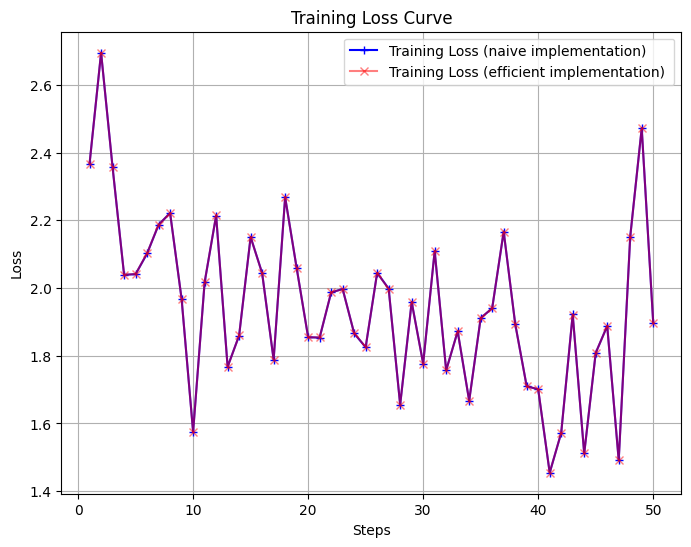

In [11]:
import matplotlib.pyplot as plt

naive_loss_values = [log["loss"] for log in naive_trainer.state.log_history if "loss" in log]
naive_steps = [log["step"] for log in naive_trainer.state.log_history if "loss" in log]  # Ensure same length

efficient_loss_values = [log["loss"] for log in efficient_trainer.state.log_history if "loss" in log]
efficient_steps = [log["step"] for log in efficient_trainer.state.log_history if "loss" in log]  # Ensure same length

plt.figure(figsize=(8, 6))
plt.plot(naive_steps, naive_loss_values, label="Training Loss (naive implementation)", color="blue", marker='+')
plt.plot(efficient_steps, efficient_loss_values, label="Training Loss (efficient implementation) ", color="red", alpha=0.5, marker='x')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()


## Marking Criteria for E) Max points = 10
```python
if attemped_E:
    E_score = 0
    if VRAM_50_percent_reduction: E_score += 2
    if remove_float32_upcast: E_score = 0
    if show_ce_loss_works: E_score += 1
    if show_other_functions_work: E_score += 1
    if hardcoded_gradients: E_score = 0
    if allows_dynamic_chunk_sizes: E_score += 1
    if llama_1B_training_loss_matches: E_score += 1
    else: E_score = 0
    if GRPO_memory_efficient_linear_works: E_score += 4
    final_score += E_score
else:
    final_score += 0
```

---
---
---
<a name="SUBMISSION"></a>
## Submission Steps

1. All code should be in a public Github (Apache 2 Licensed)
2. Kaggle notebooks and Colab notebooks should be linked in the README, and can be accessible through Colab / Kaggle.
3. If attaching notebooks, must attach fully run ones - do not just add a notebook without running it. Kaggle notebook must be public, and run.
4. Submit the Github to https://forms.gle/crSYnsGq3t1ck5TB9 If you want to send a private repo, please add me as a Github collaborate @danielhanchen
5. Provide screenshots, graphs, plots, etc especially for training loss curves.
6. We will comment and respond inside your Github repo. There will get 1 interview as well as a final step!

### Clarifications:
1. We'll compensate you if we interview you but don't hire you
2. \$100-\$1000 bounties for Task 4
3. Submissions must be Apache-2 licensed
4. Task 4 involves solving Github issues for OSS Unsloth
5. No time limit: rolling basis
6. US based preferred